In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow-addons
!pip install pyyaml h5py
!pip install toolz scikit-allel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 31.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.2 MB 173 kB/s 


In [ ]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Tensorflow version 2.9.2


## Setup

In [ ]:
import os
# os.environ["MODIN_CPUS"] = "8"
# from distributed import Client
# client = Client()
import numpy as np
import math
import re
import itertools
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_addons as tfa
from sklearn import metrics
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import constraints
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras.applications import efficientnet as efn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from tensorflow.keras.constraints import Constraint
# import allel
from scipy.spatial.distance import squareform
%matplotlib inline   
from toolz import interleave
from tqdm import tqdm
import allel
from scipy.spatial.distance import squareform
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.model_selection import KFold,StratifiedKFold

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.9.2


## Hardware Config

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    TPU = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', TPU.master())
except ValueError:
    print('Running on GPU')
    TPU = None

if TPU:
    tf.config.experimental_connect_to_cluster(TPU)
    tf.tpu.experimental.initialize_tpu_system(TPU)
    strategy = tf.distribute.experimental.TPUStrategy(TPU)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

N_REPLICAS = strategy.num_replicas_in_sync
# Number of computing cores, is 8 for a TPU V3-8
print(f'N_REPLICAS: {N_REPLICAS}')

Running on GPU
N_REPLICAS: 1


## Prepare the data

In [ ]:
root_dir = '[path]/'
new_data_header = ""
# get header
with open(root_dir + "DELL.chr22.genotypes.for.modeling.vcf", 'r') as f_in:
    # skip info
    for line_num in range(70):
        f_in.readline()

    new_data_header = f_in.readline()
# load data

# load genotype
genotypes = pd.read_csv(root_dir + "DELL.chr22.genotypes.for.modeling.vcf", comment='#', sep='\t', names=new_data_header.strip().split('\t'), header=1, index_col='Sample_id', dtype={'Sample_id':str}).iloc[:, :-1]
headers = genotypes.columns[:]
genotypes

,1,2,3,4,7,8,10,13,15,16,...,834,835,836,837,838,839,840,842,843,846
Sample_id,,,,,,,,,,,,,,,,,,,,,
HG00097,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,...,0|0,0|0,0|1,0|0,0|0,0|0,0|0,0|0,0|0,0|0
HG00099,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
HG00100,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
HG00101,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
HG00102,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NA21137,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
NA21141,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,...,0|0,0|0,1|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
NA21142,0|0,0|0,0|0,0|0,0|0,0|0,0|1,0|0,0|0,0|0,...,0|0,0|0,1|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0


In [ ]:
ped_file = '[path]/integrated_call_samples.20130502.ALL.ped'
pedigree = pd.read_csv(ped_file, sep='\t', index_col='Individual ID')

In [ ]:
pedigree.head()

,Family ID,Paternal ID,Maternal ID,Gender,Phenotype,Population,Relationship,Siblings,Second Order,Third Order,Children,Other Comments
Individual ID,,,,,,,,,,,,
HG00096,HG00096,0,0,1,0,GBR,unrel,0,0,0,0,0
HG00097,HG00097,0,0,2,0,GBR,unrel,0,0,0,0,0
HG00098,HG00098,0,0,1,0,GBR,unrel,0,0,0,0,0
HG00099,HG00099,0,0,2,0,GBR,unrel,0,0,0,0,0
HG00100,HG00100,0,0,2,0,GBR,unrel,0,0,0,0,0


In [ ]:
Y_train = pedigree.loc[genotypes.index]['Population']
# Y_train = pedigree.loc[genotypes.index][pedigree.loc[genotypes.index]['Population'] == "YRI"]['Population']
# Y_train = pd.concat((Y_train, Y_train))
Y_train.shape

(2503,)

In [ ]:
X = genotypes[genotypes.index.isin(Y_train.index)]
X.shape

(2503, 572)

In [ ]:
X = X.replace({
    '0|0': 0,
    '0|1': 1,
    '1|0': 2,
    '1|1': 3
})
X.shape

(2503, 572)

## LD

In [ ]:
r = allel.rogers_huff_r(X.T)
LD = squareform(r ** 2)
LD.shape

(572, 572)

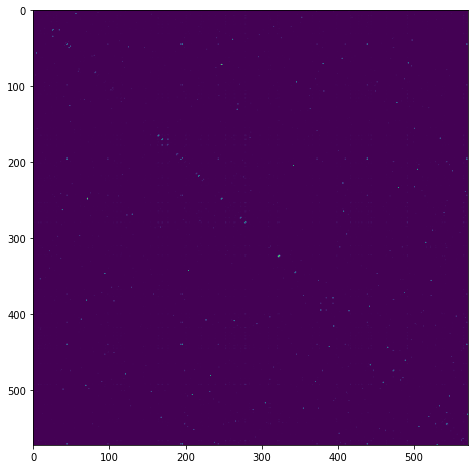

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(LD)

(array([421.,  44.,  29.,  31.,  47.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 <a list of 5 Patch objects>)

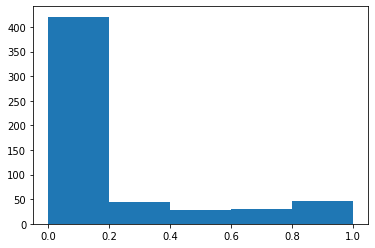

In [ ]:
bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
plt.hist(np.amax(LD, axis=1), bins=bins)

In [ ]:
LD_max_freqs = np.amax(LD, axis=1)
bin_labels = np.digitize(LD_max_freqs, bins=bins, right=True)
bin_general_labels, bin_counts = np.unique(bin_labels, return_counts=True)
bin_general_labels, bin_counts

(array([1, 2, 3, 4, 5]), array([421,  44,  29,  31,  47]))

In [ ]:
# hyperparameters
feature_size = X.shape[1]
inChannel = 5
# optimizer learning rate
learning_rate = 0.001
epochs = 60 
#epochs = 100   # chr20 LOS 5K


# training batch size
#batch_size = 32   # u19, 4984 samples
bs = 32


lr = 1e-3



# l1 regulalization
kr = 1e-4
k_initial = 'glorot_uniform'


# channel = inChannel
channel = inChannel

ndf_num = 128
kernel_len = 32
num_latent = ndf_num*4
p_size = 2



#dr_rate = drop_prec
dr_rate = 0.2  # avoid overfitting for missing ratio of 0.7

## Model

In [ ]:
# AE model in one cell
# # V1: verify our own ae model with yeast genotype data

# # 2.2.8 build variatial autoencoder for snp with subclassing function. 

class SNP_ENCODER(tf.keras.Model):    
    def __init__(self, feature_size, channel=channel, ndf=ndf_num, kernel_len=kernel_len, n_latent=num_latent, dr=dr_rate):    
        super(SNP_ENCODER, self).__init__()
        self.feature_size = feature_size
        self.channel = channel
        self.ndf = ndf
        self.n_latent = n_latent
        self.dr = dr # dropout rate

        # object, can be saved in tf mode
        self.stride=1
        self.kl = kernel_len

        
    def build(self, inputs): 
        #encoder
        # dense layer 1
        self.c1 = layers.Conv1D(filters=self.ndf, kernel_size=self.kl, strides=self.stride, padding="same", 
                      activation='relu', use_bias=True, 
                      kernel_initializer=k_initial, kernel_regularizer=tf.keras.regularizers.L1(kr), 
                      input_shape=(self.feature_size, self.channel))
        self.p1 = layers.MaxPooling1D(pool_size=p_size)
        self.drop1 = layers.Dropout(rate=self.dr)
        
        # dense layer 2
        self.c2 = layers.Conv1D(filters=(2*self.ndf), kernel_size=self.kl, strides=self.stride, padding="same", 
                      activation='relu', use_bias=True, kernel_initializer=k_initial, 
                      kernel_regularizer=tf.keras.regularizers.L1(kr))
        self.p2 = layers.MaxPooling1D(pool_size=p_size)
        self.drop2 = layers.Dropout(rate=self.dr)
        
        # dense layer 3
        self.c3 = layers.Conv1D(filters=(4*self.ndf), kernel_size=self.kl, strides=1, padding="same", 
                      activation='relu', use_bias=True, kernel_initializer=k_initial, 
                      kernel_regularizer=tf.keras.regularizers.L1(kr))
        self.p3 = layers.MaxPooling1D(pool_size=p_size)
        self.drop3 = layers.Dropout(rate=self.dr)

        super(SNP_ENCODER, self).build(inputs)
    
    def call(self, inputs, training=True):
        #print('SNP_ENCODER training flag: ', training)
        x = self.c1(inputs)
        x = self.p1(x)
        x = self.drop1(x, training=training)

        x = self.c2(x)
        x = self.p2(x)
        x = self.drop2(x, training=training)
        
        x = self.c3(x)
        return x

    # AFAIK: The most convenient method to print model.summary() 
    # similar to the sequential or functional API like.
    def build_graph(self):
        x = layers.Input(shape=(self.feature_size, self.channel))
        return tf.keras.Model(inputs=[x], outputs=self.call(x))
    
    
    
# SNP_DECODER(keras.Model):   
class SNP_DECODER(tf.keras.Model):     
    def __init__(self, feature_size, channel=channel, ndf=ndf_num, kernel_len=kernel_len, n_latent=num_latent, dr=dr_rate):
        super(SNP_DECODER, self).__init__()
        self.feature_size = feature_size
        self.channel = channel
        self.ndf = ndf
        self.n_latent = n_latent
        self.dr = dr # dropout rate
        
        # object, can be saved in tf mode
        self.stride=1
        self.kl=kernel_len
        
    def build(self, inputs):
        #decoder        
        self.c1 = layers.Conv1D(filters=(2*self.ndf), kernel_size=self.kl, strides=self.stride, padding="same", 
                      activation='relu', use_bias=True, 
                      kernel_initializer=k_initial, kernel_regularizer=tf.keras.regularizers.L1(kr),
                      input_shape=((self.feature_size>>2), self.n_latent))
        
        
        self.s1 = layers.UpSampling1D(size=p_size)
        self.drop1 = layers.Dropout(rate=self.dr)
        
        # dense layer 2
        self.c2 = layers.Conv1D(filters=(1*self.ndf), kernel_size=self.kl, strides=self.stride, padding="same", 
                      activation='relu', use_bias=True, 
                      kernel_initializer=k_initial, kernel_regularizer=tf.keras.regularizers.L1(kr))

        self.s2 = layers.UpSampling1D(size=p_size)
        self.drop2 = layers.Dropout(rate=self.dr)
        

        # dense layer6
        self.c3 = layers.Conv1D(filters=self.channel, kernel_size=self.kl, strides=1, padding="same", 
                      activation='softmax', use_bias=True)
        
        super(SNP_DECODER, self).build(inputs)
        
    def call(self, inputs, training = True):
        #print('SNP_DECODER training flag: ', training)
        x = self.c1(inputs)
        x = self.s1(x)
        x = self.drop1(x, training=training)
        
        x = self.c2(x)
        x = self.s2(x)
        x = self.drop2(x, training=training)

        
        d_out = self.c3(x)
        return d_out
    
    # AFAIK: The most convenient method to print model.summary() 
    # similar to the sequential or functional API like.
    def build_graph(self):
        x = layers.Input(shape=(self.feature_size>>2, self.n_latent))
        
        return tf.keras.Model(inputs=[x], outputs=self.call(x))
    

    
#class SNP_AE(keras.Model):
class SNP_AE(tf.keras.Model):    
    def __init__(self, feature_size, channel=channel, ndf=ndf_num, n_latent=num_latent, dr=dr_rate):    
        super(SNP_AE, self).__init__()
        self.feature_size = feature_size
        self.channel = channel
        self.ndf = ndf
        self.n_latent = n_latent
        self.dr = dr # dropout rate      
        
        self.encoder = SNP_ENCODER(self.feature_size)
        self.decoder = SNP_DECODER(self.feature_size)
    

    def call(self, x, training=True): 
        latent = self.encoder(x, training)     
        res = self.decoder(latent, training)

        return res, latent
    
    # AFAIK: The most convenient method to print model.summary() 
    # similar to the sequential or functional API like.
    def build_graph(self):
        x = layers.Input(shape=(self.feature_size, self.channel))
        return tf.keras.Model(inputs=[x], outputs=self.call(x))
    

In [ ]:
# plot snp vae encoder model

SNP_encoder = SNP_ENCODER(feature_size)
SNP_encoder.build((None, feature_size, channel))
SNP_encoder.build_graph().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 572, 5)]          0         
                                                                 
 conv1d (Conv1D)             (None, 572, 128)          20608     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 286, 128)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 286, 128)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 256)          1048832   
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 143, 256)         0         
 1D)                                                         

In [ ]:
# plot snp vae decoder model

SNP_decoder = SNP_DECODER(feature_size)

SNP_decoder.build((None, feature_size>>2, num_latent))
SNP_decoder.build_graph().summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 143, 512)]        0         
                                                                 
 conv1d_3 (Conv1D)           (None, 143, 256)          4194560   
                                                                 
 up_sampling1d (UpSampling1D  (None, 286, 256)         0         
 )                                                               
                                                                 
 dropout_3 (Dropout)         (None, 286, 256)          0         
                                                                 
 conv1d_4 (Conv1D)           (None, 286, 128)          1048704   
                                                                 
 up_sampling1d_1 (UpSampling  (None, 572, 128)         0         
 1D)                                                       

In [ ]:
# plot snp vae model

SNP_ae = SNP_AE(feature_size)
SNP_ae.build((None, feature_size, channel))
SNP_ae.build_graph().summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 572, 5)]          0         
                                                                 
 snp_encoder_1 (SNP_ENCODER)  (None, 143, 512)         5264256   
                                                                 
 snp_decoder_1 (SNP_DECODER)  (None, 572, 5)           5263749   
                                                                 
Total params: 10,528,005
Trainable params: 10,528,005
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# AE model sub-functions

def generate_fake_missing(x_in, missing_ratio=0.5):

        # Generates missing genotypes
        # different missing loci for each individuals
        x_fake = x_in.copy()   # with .copy() to not overwrite the original data
        
        for i in range(x_in.shape[0]):
            missing_size = int(missing_ratio * x_in.shape[1])
          
            # without repeat random numbers: set replace with false
            missing_index = np.random.choice(x_in.shape[1], size=missing_size, replace=False)
            
            # missing loci are encoded as [0, 0]
            # x_fake[i, missing_index, :] = [0, 0, 1]  # yeast
            x_fake[i, missing_index, :] = [0, 0, 0, 0, 1]  # human

        return x_fake
        #return x_fake, x_in
    
    

def loss_function_cce(recon_x, x):
    # orders: y_true, y_pred
    cce = tf.keras.losses.categorical_crossentropy(x, recon_x)

    #cce = np.double(cce)
    cce = K.cast(cce, dtype='float32')

    lamb1 = 1.0
    loss = lamb1*cce
    #print('loss:', loss)
    
    loss = tf.reduce_mean(loss)
    #print('ave loss:', loss)
    
    return loss


## Training

In [ ]:
# With constraint
N_SPLITS=3
results = None
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=2022)
fold = 0
_x = tf.keras.utils.to_categorical(X[X.index.isin(Y_train.index)].to_numpy(), inChannel)
_y = Y_train.to_numpy()
for train_index, test_index in kf.split(_x):
  fold += 1
  accuracies = []
  print(f"Training using fold {fold}")
  print("*******************************************")
  print("*******************************************")
  
  x_train, y_train, test_dataset, test_indices = _x[train_index], _y[train_index], (_x[test_index], _y[test_index]),Y_train.index[test_index]
  x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.10,
                                      random_state=fold,
                                      shuffle=True,
                                      stratify=y_train)
  
  
  for missing_ratio in [
                        0.05,
                        0.1,
                        0.2
                        ]:
    train_X = np.copy(x_train)
    valid_X = np.copy(x_valid)
    print(f"Missing rate {missing_ratio}")
    print("=====================================================")
    train_X_fake = generate_fake_missing(train_X, missing_ratio)

    diff = np.absolute(np.array(train_X) - np.array(train_X_fake))
    print('train_X_fake diff:', np.sum(diff))


    valid_X_fake = generate_fake_missing(valid_X, missing_ratio)
    diff = np.absolute(np.array(valid_X) - np.array(valid_X_fake))
    print('valid_X_fake diff:', np.sum(diff))


    K.clear_session()
    with strategy.scope():
      model = SNP_AE(feature_size)
      optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

      train_loss_metric = tf.keras.metrics.CategoricalCrossentropy()
      val_loss_metric = tf.keras.metrics.CategoricalCrossentropy()

      train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
      val_acc_metric = tf.keras.metrics.CategoricalAccuracy()

      for epoch in range(epochs):
        print('Start of epoch %d' % (epoch,))

        #----shuffle train data and lablel for each epoch-----------------------------------------------------------------------------------#    
        # shuffle data and labels at the same time
        idx = train_X.shape[0]


        indices = tf.range(start=0, limit=idx, dtype=tf.int32)

        shuffled_indices = tf.random.shuffle(indices)  
      
        train_X_fake = tf.gather(train_X_fake, shuffled_indices)
        train_X = tf.gather(train_X, shuffled_indices)        
        
        snp_x = tf.data.Dataset.from_tensor_slices(train_X_fake).batch(bs, drop_remainder=True) 
        snp_y = tf.data.Dataset.from_tensor_slices(train_X).batch(bs, drop_remainder=True)

        snp_x_v = tf.data.Dataset.from_tensor_slices(valid_X_fake).batch(bs, drop_remainder=True)
        snp_y_v = tf.data.Dataset.from_tensor_slices(valid_X).batch(bs, drop_remainder=True)

        loss_batch = []

        # Iterate over the batches of the dataset.
        for step, (snp_fake_batch, snp_label_batch) in enumerate(zip(snp_x, snp_y)): 
          with tf.GradientTape() as tape:
              recon_inputs, latents= model(snp_fake_batch, training=True)
              loss = loss_function_cce(recon_inputs, snp_label_batch)


          grads = tape.gradient(loss, model.trainable_variables)
          optimizer.apply_gradients(zip(grads, model.trainable_variables))    

          loss_batch.append(loss.numpy())


          # Update training metric.
          train_acc_metric.update_state(snp_label_batch, recon_inputs)
          train_loss_metric.update_state(snp_label_batch, recon_inputs)


        # Display metrics at the end of each epoch.
        train_loss = train_loss_metric.result()
        print("Training loss over epoch: ", epoch, train_loss.numpy())

        train_acc = train_acc_metric.result()
        print("Training acc over epoch: ", epoch, train_acc.numpy())


        # Reset training metrics at the end of each epoch
        train_loss_metric.reset_states()
        train_acc_metric.reset_states()


        # Run a validation loop at the end of each epoch.
        for x_batch_val, y_batch_val in zip(snp_x_v, snp_y_v):   

            val_recons, latents = model(x_batch_val, training=False)
            # Update val metrics
            val_loss_metric.update_state(y_batch_val, val_recons)
            val_acc_metric.update_state(y_batch_val, val_recons)

        val_loss = val_loss_metric.result()
        val_acc = val_acc_metric.result()

        val_loss_metric.reset_states()
        val_acc_metric.reset_states()
        #print("Validation acc: %.4f" % (float(val_acc),))
        print("Validation loss: ", epoch, val_loss.numpy())
        print("Validation acc: ", epoch, val_acc.numpy())


        #print('epoch %s: batch loss = %s' % (epoch, loss_batch))
        loss_epoch = np.mean(loss_batch)    
        print('epoch %s: loss = %s' % (epoch, loss_epoch))    
    
    save_name = f"[path]/Chr.22.DELS/AE/preds_mixed_mr_{missing_ratio}_fold_{fold}_.csv"
    avg_accuracy = []
    preds = []
    true_labels = []
    
    to_save_array = np.zeros((test_dataset[0].shape[0], test_dataset[0].shape[1]), dtype=object)
    test_X_missing = np.copy(test_dataset[0])
    for i in tqdm(list(range(test_dataset[0].shape[0]))):
      missing_index, _ = train_test_split(np.arange(x_train.shape[1]), train_size=missing_ratio,
                                    random_state=i + fold,
                                    shuffle=True,
                                    stratify=bin_labels
                                    )
      test_X_missing[i:i+1, missing_index, :] = [0, 0, 0, 0, 1]
      # predict
      predict_onehot, _ = model(test_X_missing[i:i+1, :, :], training=False)
      predict_onehot = predict_onehot.numpy()
      # only care the missing position
      predict_missing_onehot = predict_onehot[0:1, missing_index, :]
      # predict label
      predict_missing = np.argmax(predict_missing_onehot, axis=2)
      
      preds.extend(predict_missing.ravel().tolist())
      
      predict_haplotypes = np.argmax(predict_onehot, axis=2)
      # Only for haploids
      to_save_array[i] = predict_haplotypes
      # real label
      label_missing_onehot = np.argmax(test_dataset[0][i:i + 1, missing_index], axis=2)
      label_missing = np.argmax(test_dataset[0][i:i + 1, missing_index], axis=2)
      true_labels.extend(label_missing.ravel().tolist())
      # accuracy
      correct_prediction = np.equal(predict_missing, label_missing)
      accuracy = np.mean(correct_prediction)

      avg_accuracy.append(accuracy)

    df = pd.DataFrame(to_save_array, columns= headers[:], index = Y_train.index[test_index])
    df.to_csv(save_name)
    print('The average imputation accuracy' \
          'on test data with {} missing genotypes is {:.4f}: '
        .format(missing_ratio, np.mean(avg_accuracy)))
    cnf_matrix = confusion_matrix(true_labels, preds)
    FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)
    FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
    TP = np.diag(cnf_matrix)
    TN = cnf_matrix.sum() - (FP + FN + TP)
    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP)
    print(f"Sensitivity: {np.mean(TPR)}")
    print(f"Specificity: {np.mean(TNR)}")
    print(f"F1-score macro: {f1_score(true_labels, preds, average='macro')}")
    print(f"F1-score micro: {f1_score(true_labels, preds, average='micro')}")
    accuracies.append(np.mean(avg_accuracy))
        
    

Training using fold 1
*******************************************
*******************************************
Missing rate 0.05
train_X_fake diff: 84056.0
valid_X_fake diff: 9352.0
Start of epoch 0
Training loss over epoch:  0 1.0853944
Training acc over epoch:  0 0.88192886
Validation loss:  0 0.24688941
Validation acc:  0 0.95725524
epoch 0: loss = 1.0853946
Start of epoch 1
Training loss over epoch:  1 0.23371829
Training acc over epoch:  1 0.9581773
Validation loss:  1 0.21783091
Validation acc:  1 0.95725524
epoch 1: loss = 0.23371828
Start of epoch 2
Training loss over epoch:  2 0.21441758
Training acc over epoch:  2 0.95818806
Validation loss:  2 0.2108404
Validation acc:  2 0.95725524
epoch 2: loss = 0.21441762
Start of epoch 3
Training loss over epoch:  3 0.21018921
Training acc over epoch:  3 0.9582035
Validation loss:  3 0.2078056
Validation acc:  3 0.95725524
epoch 3: loss = 0.21018918
Start of epoch 4
Training loss over epoch:  4 0.20508015
Training acc over epoch:  4 0.95

100%|██████████| 835/835 [00:09<00:00, 90.30it/s]


The average imputation accuracyon test data with 0.05 missing genotypes is 0.9621: 
Sensitivity: 0.3715841180601184
Specificity: 0.8056639220163793
F1-score macro: 0.424443362719693
F1-score micro: 0.962147134302823
Missing rate 0.1
train_X_fake diff: 171114.0
valid_X_fake diff: 19038.0
Start of epoch 0
Training loss over epoch:  0 1.2919366
Training acc over epoch:  0 0.89929855
Validation loss:  0 0.25116706
Validation acc:  0 0.95725524
epoch 0: loss = 1.2919364
Start of epoch 1
Training loss over epoch:  1 0.23733999
Training acc over epoch:  1 0.958213
Validation loss:  1 0.22303623
Validation acc:  1 0.95725524
epoch 1: loss = 0.23734002
Start of epoch 2
Training loss over epoch:  2 0.21692754
Training acc over epoch:  2 0.9582106
Validation loss:  2 0.21252362
Validation acc:  2 0.95725524
epoch 2: loss = 0.21692757
Start of epoch 3
Training loss over epoch:  3 0.20989211
Training acc over epoch:  3 0.95816547
Validation loss:  3 0.20667566
Validation acc:  3 0.95725524
epoch 3:

100%|██████████| 835/835 [00:09<00:00, 90.17it/s]


The average imputation accuracyon test data with 0.1 missing genotypes is 0.9616: 
Sensitivity: 0.38089801137165913
Specificity: 0.8076388834950148
F1-score macro: 0.42770818668115357
F1-score micro: 0.9615505830444374
Missing rate 0.2
train_X_fake diff: 342228.0
valid_X_fake diff: 38076.0
Start of epoch 0
Training loss over epoch:  0 1.0217011
Training acc over epoch:  0 0.90546256
Validation loss:  0 0.26182538
Validation acc:  0 0.95725524
epoch 0: loss = 1.0217011
Start of epoch 1
Training loss over epoch:  1 0.23926672
Training acc over epoch:  1 0.9581999
Validation loss:  1 0.22450897
Validation acc:  1 0.95725524
epoch 1: loss = 0.23926668
Start of epoch 2
Training loss over epoch:  2 0.22070871
Training acc over epoch:  2 0.95823914
Validation loss:  2 0.22117749
Validation acc:  2 0.95725524
epoch 2: loss = 0.22070874
Start of epoch 3
Training loss over epoch:  3 0.21824297
Training acc over epoch:  3 0.9582213
Validation loss:  3 0.21788287
Validation acc:  3 0.95725524
epoc

100%|██████████| 835/835 [00:09<00:00, 91.22it/s]


The average imputation accuracyon test data with 0.2 missing genotypes is 0.9607: 
Sensitivity: 0.3987749212631229
Specificity: 0.8204495861928602
F1-score macro: 0.4393986247242958
F1-score micro: 0.9606681374093917
Training using fold 2
*******************************************
*******************************************
Missing rate 0.05
train_X_fake diff: 84112.0
valid_X_fake diff: 9352.0
Start of epoch 0
Training loss over epoch:  0 1.3363605
Training acc over epoch:  0 0.89593506
Validation loss:  0 0.2517835
Validation acc:  0 0.95823866
epoch 0: loss = 1.3363606
Start of epoch 1
Training loss over epoch:  1 0.2365734
Training acc over epoch:  1 0.9580823
Validation loss:  1 0.22185548
Validation acc:  1 0.95823866
epoch 1: loss = 0.23657341
Start of epoch 2
Training loss over epoch:  2 0.22075075
Training acc over epoch:  2 0.95810014
Validation loss:  2 0.21487027
Validation acc:  2 0.95823866
epoch 2: loss = 0.22075076
Start of epoch 3
Training loss over epoch:  3 0.2159106

100%|██████████| 834/834 [00:09<00:00, 91.03it/s]


The average imputation accuracyon test data with 0.05 missing genotypes is 0.9603: 
Sensitivity: 0.359106831894637
Specificity: 0.8029689400655825
F1-score macro: 0.4101269945963467
F1-score micro: 0.9603460089071599
Missing rate 0.1
train_X_fake diff: 171228.0
valid_X_fake diff: 19038.0
Start of epoch 0
Training loss over epoch:  0 0.757268
Training acc over epoch:  0 0.93507713
Validation loss:  0 0.23714647
Validation acc:  0 0.95823866
epoch 0: loss = 0.7572678
Start of epoch 1
Training loss over epoch:  1 0.22793907
Training acc over epoch:  1 0.95809186
Validation loss:  1 0.21692306
Validation acc:  1 0.95823866
epoch 1: loss = 0.22793907
Start of epoch 2
Training loss over epoch:  2 0.21809664
Training acc over epoch:  2 0.9580538
Validation loss:  2 0.21453907
Validation acc:  2 0.95823866
epoch 2: loss = 0.21809667
Start of epoch 3
Training loss over epoch:  3 0.21260317
Training acc over epoch:  3 0.95811087
Validation loss:  3 0.20433909
Validation acc:  3 0.95823866
epoch 

100%|██████████| 834/834 [00:09<00:00, 90.29it/s]


The average imputation accuracyon test data with 0.1 missing genotypes is 0.9604: 
Sensitivity: 0.3868174270519518
Specificity: 0.8201993801449821
F1-score macro: 0.4380486629533765
F1-score micro: 0.960431654676259
Missing rate 0.2
train_X_fake diff: 342456.0
valid_X_fake diff: 38076.0
Start of epoch 0
Training loss over epoch:  0 1.1137608
Training acc over epoch:  0 0.8058977
Validation loss:  0 0.23633438
Validation acc:  0 0.95823866
epoch 0: loss = 1.113761
Start of epoch 1
Training loss over epoch:  1 0.23693964
Training acc over epoch:  1 0.95809776
Validation loss:  1 0.2243462
Validation acc:  1 0.95823866
epoch 1: loss = 0.23693964
Start of epoch 2
Training loss over epoch:  2 0.22145322
Training acc over epoch:  2 0.95811087
Validation loss:  2 0.2172662
Validation acc:  2 0.95823866
epoch 2: loss = 0.22145319
Start of epoch 3
Training loss over epoch:  3 0.21871644
Training acc over epoch:  3 0.9581251
Validation loss:  3 0.21705967
Validation acc:  3 0.95823866
epoch 3: l

100%|██████████| 834/834 [00:09<00:00, 86.87it/s]


The average imputation accuracyon test data with 0.2 missing genotypes is 0.9596: 
Sensitivity: 0.2806598121959617
Specificity: 0.7604754688851609
F1-score macro: 0.2948768508073101
F1-score micro: 0.9595902225587951
Training using fold 3
*******************************************
*******************************************
Missing rate 0.05
train_X_fake diff: 84112.0
valid_X_fake diff: 9352.0
Start of epoch 0
Training loss over epoch:  0 0.8857779
Training acc over epoch:  0 0.9301661
Validation loss:  0 0.24072148
Validation acc:  0 0.9585992
epoch 0: loss = 0.88577807
Start of epoch 1
Training loss over epoch:  1 0.22722366
Training acc over epoch:  1 0.9580645
Validation loss:  1 0.2107494
Validation acc:  1 0.9585992
epoch 1: loss = 0.22722365
Start of epoch 2
Training loss over epoch:  2 0.21273936
Training acc over epoch:  2 0.95802176
Validation loss:  2 0.20565227
Validation acc:  2 0.9585992
epoch 2: loss = 0.21273936
Start of epoch 3
Training loss over epoch:  3 0.20706664


100%|██████████| 834/834 [00:09<00:00, 92.26it/s]


The average imputation accuracyon test data with 0.05 missing genotypes is 0.9612: 
Sensitivity: 0.36118906856387295
Specificity: 0.8016566127509914
F1-score macro: 0.4091862031554161
F1-score micro: 0.96120246659815
Missing rate 0.1
train_X_fake diff: 171228.0
valid_X_fake diff: 19038.0
Start of epoch 0
Training loss over epoch:  0 1.001059
Training acc over epoch:  0 0.94716054
Validation loss:  0 0.24007763
Validation acc:  0 0.9585992
epoch 0: loss = 1.0010589
Start of epoch 1
Training loss over epoch:  1 0.23214081
Training acc over epoch:  1 0.9580194
Validation loss:  1 0.21606444
Validation acc:  1 0.9585992
epoch 1: loss = 0.23214076
Start of epoch 2
Training loss over epoch:  2 0.2159439
Training acc over epoch:  2 0.9579861
Validation loss:  2 0.20500214
Validation acc:  2 0.9585992
epoch 2: loss = 0.2159439
Start of epoch 3
Training loss over epoch:  3 0.20923713
Training acc over epoch:  3 0.9579636
Validation loss:  3 0.20092458
Validation acc:  3 0.9585992
epoch 3: loss 

100%|██████████| 834/834 [00:09<00:00, 89.96it/s]


The average imputation accuracyon test data with 0.1 missing genotypes is 0.9604: 
Sensitivity: 0.38508299617982267
Specificity: 0.824070487053773
F1-score macro: 0.42644932904597016
F1-score micro: 0.960431654676259
Missing rate 0.2
train_X_fake diff: 342456.0
valid_X_fake diff: 38076.0
Start of epoch 0
Training loss over epoch:  0 0.9821295
Training acc over epoch:  0 0.89252055
Validation loss:  0 0.24094427
Validation acc:  0 0.9585992
epoch 0: loss = 0.9821294
Start of epoch 1
Training loss over epoch:  1 0.23953497
Training acc over epoch:  1 0.9580099
Validation loss:  1 0.22750436
Validation acc:  1 0.9585992
epoch 1: loss = 0.23953497
Start of epoch 2
Training loss over epoch:  2 0.22598037
Training acc over epoch:  2 0.9580348
Validation loss:  2 0.21740255
Validation acc:  2 0.9585992
epoch 2: loss = 0.2259804
Start of epoch 3
Training loss over epoch:  3 0.22057208
Training acc over epoch:  3 0.9580313
Validation loss:  3 0.21701379
Validation acc:  3 0.9585992
epoch 3: los

100%|██████████| 834/834 [00:09<00:00, 90.65it/s]


The average imputation accuracyon test data with 0.2 missing genotypes is 0.9616: 
Sensitivity: 0.38251349252440003
Specificity: 0.8084850054847503
F1-score macro: 0.43175155435107926
F1-score micro: 0.9615675880348353
